In [1]:
from datasets import load_dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision.models import resnet50
from torch.utils.data import Dataset,DataLoader
from torchvision.transforms import transforms
from torch.nn.utils.rnn import pad_sequence
import sentencepiece as spm
import wandb
from tqdm import tqdm
import os
from PIL import Image
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_coco_data=load_dataset('jxie/coco_captions',split='train[:20%]')
val_coco_data=load_dataset('jxie/coco_captions',split='validation[:50%]')
test_coco_data=load_dataset('jxie/coco_captions',split='test[:50%]')

In [3]:
train_coco_data

Dataset({
    features: ['image', 'filename', 'cocoid', 'caption'],
    num_rows: 113349
})

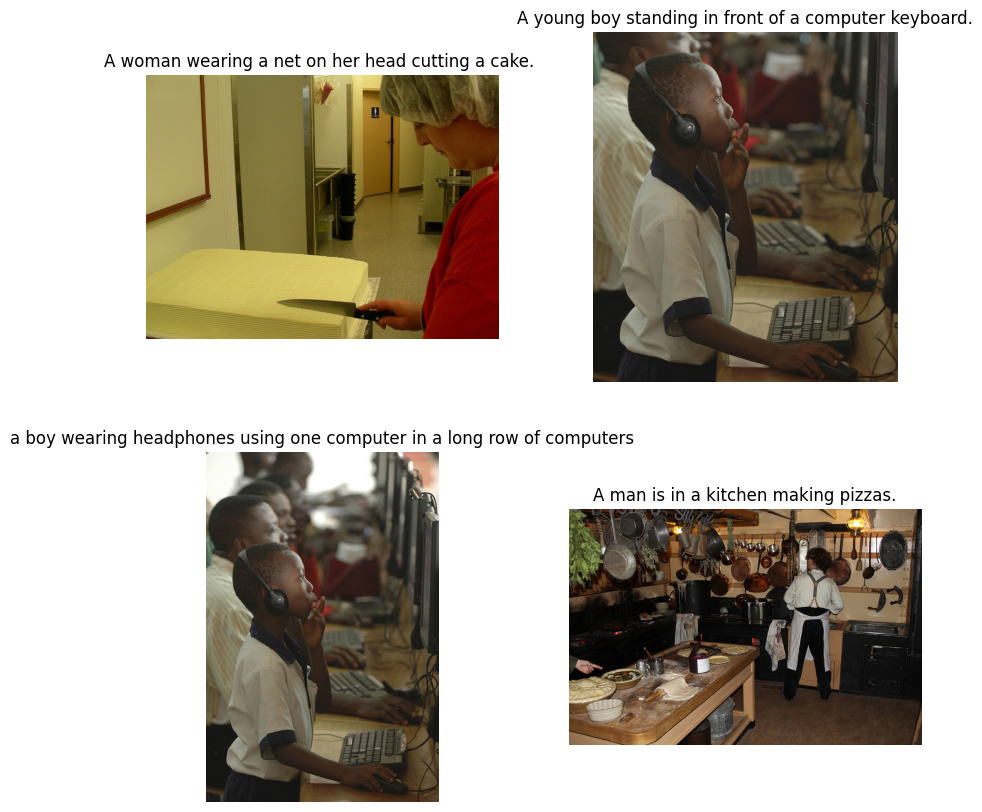

In [4]:
'''
Each image can have multiple caption, so we aim to show one picture with a caption first encountered
for this we store the prevoius img id, and chekc in the next iteration if current image id is equal to prevoius image id
if yes then we continue else display the image
'''

imgs_to_show=4
cnt=0
data_iter=iter(train_coco_data)
plt.figure(figsize=(10,10))
prev_img_id=None

while True:
    sample=next(data_iter)
    img_id=sample['cocoid']
    if prev_img_id==img_id:
        continue
    img=sample['image']
    caption=sample['caption']
    plt.subplot(2,2,cnt+1)
    plt.imshow(img)
    plt.title(caption)
    plt.axis('off')
    cnt+=1
    prev_img_id=img_id
    if cnt==imgs_to_show:
        break

### Archtecture

#### Encoder

In [5]:
model=resnet50(pretrained=True)
list(model.children())

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [6]:
class Encoder(nn.Module):
    def __init__(self,image_size,fine_tune=False):
        super(Encoder,self).__init__()
        self.image_size=image_size
        self.fine_tune=fine_tune
        self.resnet=resnet50(pretrained=True)
        if self.fine_tune:
            for params in self.resnet.parameters():
                params.requires_grad_(False)

        children=list(self.resnet.children())[:-2]
        self.resnet=nn.Sequential(*children)
        self.adaptive_pool=nn.AdaptiveAvgPool2d((image_size,image_size))  #for resizing the image
        

    def forward(self,image):
        features=self.resnet(image)    #[B,2048,h,w]
        #aatetion needs [B,h,w,2048]
        features=features.permute(0,2,3,1)
        #flatten it
        features=features.view(features.size(0),-1,features.size(-1))  #[B,49,2048] given image size is 7
        return features
        
        
        

In [7]:
class Attention(nn.Module):
    def __init__(self,encoder_dim,decoder_dim,attention_dim):
        super(Attention,self).__init__()

        self.encoder_attn=nn.Linear(encoder_dim,attention_dim)  #project decoder dim
        self.decoder_attn=nn.Linear(decoder_dim,attention_dim)   #project encoder dim
        self.attn=nn.Linear(attention_dim,1)
        self.tanh=torch.tanh
        

    def forward(self,features,hidden_state):
        encoder_proj=self.encoder_attn(features)  #[B,49,attn_dim]
        decoder_proj=self.decoder_attn(hidden_state) #[B,attn_dim]

        #attention scores calculate
        attn_scores=self.tanh(encoder_proj+decoder_proj.unsqueeze(1))   #[B,49,attn_dim] + [B,1,attn_dim]
        attn_scores=self.attn(attn_scores)    #[B,49,1]
        #apply softmax
        
        attn_scores=F.softmax(attn_scores.squeeze(2),dim=1)  #[B,49]

        context=torch.sum(features*attn_scores.unsqueeze(2),dim=1)

        return attn_scores,context        

In [8]:
class Decoder(nn.Module):
    def __init__(self,encoder_dim,decoder_dim,embed_dim,attention_dim,vocab_size,dropout):
        super(Decoder,self).__init__()
        self.embed_dim=embed_dim
        self.decoder_dim=decoder_dim
        self.embed=nn.Embedding(vocab_size,embed_dim)
        self.attention=Attention(encoder_dim,decoder_dim,attention_dim)
        self.lstm_cell=nn.LSTMCell(encoder_dim+embed_dim,decoder_dim)
        self.dropout=dropout
        self.generate_word=nn.Linear(decoder_dim,vocab_size)

        self.init_hidden_state=nn.Linear(encoder_dim,decoder_dim)
        self.init_cell_state=nn.Linear(encoder_dim,decoder_dim)
        self.embed.weight.data.uniform_(-0.1,0.1)
        self.generate_word.weight.data.uniform_(-0.1,0.1)
        


    def init_hidden_cell(self,features):
        mean_features=torch.mean(features,dim=1)
        h=self.init_hidden_state(mean_features)
        c=self.init_cell_state(mean_features)

        return h,c

    def forward(self,features,captions):  #captions is a list of tokens
        predicted_word_logits=[]
        
        #initialise the weights
        h,c=self.init_hidden_cell(features)
        captions_len=captions.size(1)
        for t in range(captions_len):
            word=captions[:,t]
            embed_word=self.embed(word)
            attention_score,context=self.attention(features,h)

            h,c=self.lstm_cell(torch.cat([embed_word,context],dim=1),(h,c))
            predicted_word=self.generate_word(h)
            predicted_word_logits.append(predicted_word)

            
            

        predicted_word_logits=torch.stack(predicted_word_logits,dim=1)
        return predicted_word_logits,h,c        

In [9]:
#create a custom data class
class ImageData(Dataset):
    def __init__(self,data,tokenizer,transforms):
        self.data=data
        self.transforms=transforms
        self.tokenizer=tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        image=self.data[idx]['image']
        if isinstance(image,Image.Image):
            image=image.convert('RGB')
        image=self.transforms(image)
        captions=self.data[idx]['caption']
        if self.tokenizer==sp_tokenizer:
            tokenized_captions_id=[sp_tokenizer.bos_id()]+sp_tokenizer.encode(captions,out_type=int)+[sp_tokenizer.eos_id()]
            tokenized_captions=sp_tokenizer.encode(captions,out_type=str)

        return {
            'image':image,
            'input_ids':torch.tensor(tokenized_captions_id[:-1]),
            'target_ids':torch.tensor(tokenized_captions_id[1:])}
        

In [10]:
def collate_fn(batch):
    image=[sample['image'] for sample in batch]
    input_ids=[sample['input_ids'] for sample in batch]
    target_ids=[sample['target_ids'] for sample in batch]

    padding_token_id=sp_tokenizer.pad_id()

    padded_input_ids=pad_sequence(input_ids,batch_first=True,padding_value=padding_token_id)
    padded_target_ids=pad_sequence(target_ids,batch_first=True,padding_value=padding_token_id)
    image=torch.stack(image)

    return {'image':image,
            'input_ids':padded_input_ids,
            'target_ids':padded_target_ids}

In [11]:
#create data loader
#create vocabulary, for vocabulary we will use sentence piece

def create_captions_file():
    with open('./captions_new.txt','w') as file:
        data_iter=iter(train_coco_data)
        for i in range(len(train_coco_data)):
            sample=next(data_iter)
            caption=sample['caption']
            file.write(caption+"\n")


create_captions_file()

spm.SentencePieceTrainer.Train(
    '--input=captions_new.txt '
    '--model_prefix=caption_sp '
    '--vocab_size=2372 '
    '--model_type=unigram '
    '--character_coverage=1.0 '
    '--pad_id=0 '
    '--bos_id=1 '
    '--eos_id=2 '
    '--unk_id=3'
)

sp_tokenizer=spm.SentencePieceProcessor(model_file='caption_sp.model')

sentencepiece_trainer.cc(178) LOG(INFO) Running command: --input=captions_new.txt --model_prefix=caption_sp --vocab_size=2372 --model_type=unigram --character_coverage=1.0 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: captions_new.txt
  input_format: 
  model_prefix: caption_sp
  model_type: UNIGRAM
  vocab_size: 2372
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  har

In [12]:
def train(train_loader, encoder, decoder, encoder_optim, decoder_optim, criterion, vocab_size, gradient_clipping):
    total_loss = 0
    decoder.train()
    

    for idx, sample in enumerate(tqdm(train_loader)):
        image = sample['image'].to(device)
        input_ids = sample['input_ids'].to(device)
        target_ids = sample['target_ids'].to(device)

        features = encoder(image)

        encoder_optim.zero_grad()
        decoder_optim.zero_grad()

        preds,h,c = decoder(features, input_ids[:,:-1])

        loss = criterion(preds.view(-1, vocab_size), target_ids[:,1:].reshape(-1))
        total_loss += loss.item()

        loss.backward()

        if gradient_clipping:
            torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=gradient_clipping)
            

        decoder_optim.step()
        

    return total_loss / len(train_loader)

In [13]:
def validate(val_loader,decoder,encoder,criterion,vocab_size):
    val_loss=0
    decoder.eval()
    with torch.no_grad():
        for sample in tqdm(val_loader):
            image=sample['image'].to(device)
            input_ids=sample['input_ids'].to(device)
            target_ids=sample['target_ids'].to(device)

            #pass the image to encoder
            features=encoder(image)
            preds,h,c = decoder(features, input_ids[:,:-1])
            loss = criterion(preds.view(-1, vocab_size), target_ids[:,1:].reshape(-1))

            val_loss+=loss.item()

        avg_val_loss=val_loss/len(val_loader)

        return avg_val_loss
            

In [14]:

transforms=transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),   #image is PIL, need to convert to tensor
                                transforms.Normalize((0.485,0.486,0.406),(0.229,0.224,0.225))])
tokenizer=sp_tokenizer

#convert to our custom dataset object
train_dataset=ImageData(train_coco_data,tokenizer,transforms)
val_dataset=ImageData(val_coco_data,tokenizer,transforms)
test_dataset=ImageData(test_coco_data,tokenizer,transforms)

In [15]:
#create data loaders
train_loader=DataLoader(train_dataset,batch_size=32,collate_fn=collate_fn)
val_loader=DataLoader(val_dataset,batch_size=32,collate_fn=collate_fn)
test_loader=DataLoader(test_dataset,batch_size=32,collate_fn=collate_fn)

In [16]:
#hyperparameters
#train
device='cuda' if torch.cuda.is_available() else 'cpu'
print(f"using device {device}")

encoder_dim=2048
decoder_dim=512
attention_dim=256
image_size=512
vocab_size=2372
embed_dim=512
dropout=0.5
gradient_clipping=4.

encoder=Encoder(image_size,fine_tune=False).to(device)
print("encoder initialised")
decoder=Decoder(encoder_dim,decoder_dim,embed_dim,attention_dim,vocab_size,dropout).to(device)
print("decoder initialised")


encoder_optim=torch.optim.Adam(encoder.parameters(),lr=1e-4)
decoder_optim=torch.optim.Adam(decoder.parameters(),lr=1e-4)

criterion=nn.CrossEntropyLoss()

wandb.log=True
wandb.init(project="Image caption generator",
           name="new run 3")

epochs=20
best_loss=float('inf')
print("starting training")
for epoch in range(epochs):
    train_loss=train(train_loader,encoder,decoder,encoder_optim,decoder_optim,criterion,vocab_size,gradient_clipping)
    val_loss=validate(val_loader,decoder,encoder,criterion,vocab_size)
    print(f"epoch [{epoch+1}/{epochs}] train loss: {train_loss}, val loss: {val_loss}")

    wandb.log({'train loss':train_loss,
               'val loss':val_loss})

    if val_loss<best_loss:
        best_loss=val_loss
        torch.save({"encoder":encoder.state_dict(),
                    "decoder":decoder.state_dict()},'./best_model.pt')
        print(f"best model saved at epoch {epoch+1}")
    

using device cuda
encoder initialised
decoder initialised


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: venky_ai (venky_ai-lule-university-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


starting training


100%|██████████| 391/391 [02:43<00:00,  2.39it/s]


epoch [1/20] train loss: 2.8184434931021842, val loss: 2.6143489914477023
best model saved at epoch 1


100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


epoch [2/20] train loss: 2.4980367370624847, val loss: 2.4295013630786517
best model saved at epoch 2


 17%|█▋        | 586/3543 [05:32<27:10,  1.81it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


epoch [4/20] train loss: 2.265639530108401, val loss: 2.294617708076906
best model saved at epoch 4


100%|██████████| 391/391 [02:45<00:00,  2.36it/s]


epoch [5/20] train loss: 2.197910459725291, val loss: 2.2597890590767724
best model saved at epoch 5


100%|██████████| 391/391 [02:42<00:00,  2.40it/s]


epoch [6/20] train loss: 2.1415524642547576, val loss: 2.2374099270462073
best model saved at epoch 6


100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


epoch [7/20] train loss: 2.0921166243103646, val loss: 2.219958318011535
best model saved at epoch 7


100%|██████████| 391/391 [02:46<00:00,  2.35it/s]


epoch [8/20] train loss: 2.0473763410095573, val loss: 2.2073801885480466
best model saved at epoch 8


100%|██████████| 391/391 [02:46<00:00,  2.34it/s]


epoch [9/20] train loss: 2.006245508070824, val loss: 2.198291933292623
best model saved at epoch 9


100%|██████████| 391/391 [02:46<00:00,  2.34it/s]


epoch [10/20] train loss: 1.9678815408611647, val loss: 2.1927748642614127
best model saved at epoch 10


100%|██████████| 391/391 [02:44<00:00,  2.37it/s]


epoch [11/20] train loss: 1.931916907282492, val loss: 2.190593025263618
best model saved at epoch 11


100%|██████████| 391/391 [02:43<00:00,  2.38it/s]


epoch [12/20] train loss: 1.8974377372626225, val loss: 2.1946449935283807


100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


epoch [13/20] train loss: 1.8649771008456524, val loss: 2.195837756556928


100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


epoch [14/20] train loss: 1.8339551208956646, val loss: 2.198231995867951


100%|██████████| 391/391 [02:43<00:00,  2.40it/s]


epoch [15/20] train loss: 1.8041509844608776, val loss: 2.199590418802198


100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


epoch [16/20] train loss: 1.7763407664247868, val loss: 2.2067024582792123


100%|██████████| 391/391 [02:48<00:00,  2.32it/s]


epoch [17/20] train loss: 1.75036905411102, val loss: 2.21379156597435


100%|██████████| 391/391 [02:44<00:00,  2.38it/s]


epoch [18/20] train loss: 1.7253578786220114, val loss: 2.2213702759779324


100%|██████████| 391/391 [02:44<00:00,  2.37it/s]


epoch [19/20] train loss: 1.701165202661251, val loss: 2.2328836128229983


100%|██████████| 391/391 [02:46<00:00,  2.35it/s]

epoch [20/20] train loss: 1.6760572993987501, val loss: 2.239155326657893


### Testing the model

In [25]:
#load best model
best_model=torch.load('./best_model.pt')
encoder.load_state_dict(best_model['encoder'])
decoder.load_state_dict(best_model['decoder'])

encoder.to(device)
decoder.to(device)

Decoder(
  (embed): Embedding(2372, 512)
  (attention): Attention(
    (encoder_attn): Linear(in_features=2048, out_features=256, bias=True)
    (decoder_attn): Linear(in_features=512, out_features=256, bias=True)
    (attn): Linear(in_features=256, out_features=1, bias=True)
  )
  (lstm_cell): LSTMCell(2560, 512)
  (generate_word): Linear(in_features=512, out_features=2372, bias=True)
  (init_hidden_state): Linear(in_features=2048, out_features=512, bias=True)
  (init_cell_state): Linear(in_features=2048, out_features=512, bias=True)
)

In [26]:
encoder

Encoder(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [64]:
### def testing function
def generate_captions(encoder,decoder,image,tokenizer,max_len=50):

    decoder.eval()
    image=image.to(device)
    with torch.no_grad():
        captions=[tokenizer.bos_id()]
        features=encoder(image.unsqueeze(0)).to(device)
        h,c=decoder.init_hidden_cell(features)
        for _ in range(max_len):
            input_ids=torch.tensor([captions[-1]]).unsqueeze(0).to(device)
            embed_word=decoder.embed(input_ids).squeeze(1)

            #attention
            score,context=decoder.attention(features,h)

            #feed to lstm cell
            h,c = decoder.lstm_cell(torch.cat([embed_word, context], dim=1),(h,c))
            logit=decoder.generate_word(h)
            word=logit.argmax(1).item()
            # if word==tokenizer.eos_id():
            #     break
            captions.append(word)
    
    print(tokenizer.decode(captions, out_type=str))
    decoded_words=tokenizer.decode(captions[1:])
    return decoded_words
            
            

In [65]:
sample=next(iter(test_loader))
image=sample['image'][0]
cap=generate_captions(encoder,decoder,image,sp_tokenizer,max_len=50)

man on motorcycle in field trees a


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0295868..2.64].


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

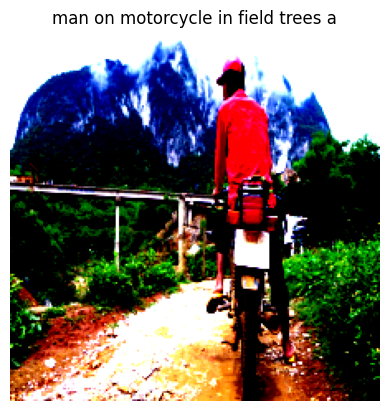

In [53]:
image=image.permute(1,2,0).numpy()
plt.imshow(image)
plt.title(cap)
plt.axis('off')

In [68]:
def beam_search(encoder, decoder, image, tokenizer, beam_size=3, max_len=20):
    decoder.eval()
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        #get features
        features = encoder(image)  #[1, 49, 2048]
        h, c = decoder.init_hidden_cell(features)
        beams = [([tokenizer.bos_id()], 0.0, h, c)]

        for _ in range(max_len):
            candidates = []

            for seq, score, h, c in beams:
                input_id=torch.tensor([seq[-1]]).unsqueeze(0).to(device)
                embedded=decoder.embed(input_id).squeeze(1)
                _,context=decoder.attention(features, h)
                h_new,c_new=decoder.lstm_cell(torch.cat([embedded, context], dim=1), (h, c))
                output=decoder.generate_word(h_new)  # logits
                log_probs=torch.log_softmax(output, dim=1)

                topk_probs,topk_idx=torch.topk(log_probs,beam_size, dim=1)

                for i in range(beam_size):
                    next_word=topk_idx[0, i].item()
                    next_score=score+topk_probs[0, i].item()
                    next_seq=seq+[next_word]
                    candidates.append((next_seq,next_score,h_new,c_new))

            #sort by score and keep top k
            beams=sorted(candidates,key=lambda x:x[1],reverse=True)[:beam_size]

            #check eos
            if all(seq[-1]==tokenizer.eos_id() for seq,_,_,_ in beams):
                break

        final_seq=beams[0][0]
        print(tokenizer.decode(final_seq, out_type=str))
        decoded=tokenizer.decode(final_seq[1:], out_type=str)
        return decoded
            
            

        
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0295868..2.64].


man a on motorcycle in middle a lot trees


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

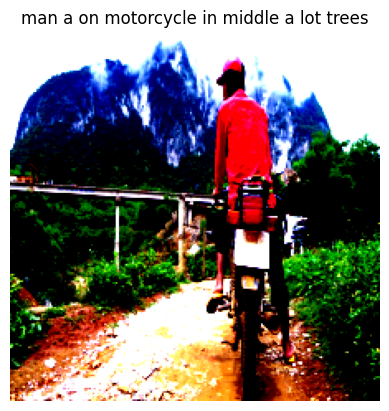

In [69]:
sample=next(iter(test_loader))
image=sample['image'][0]
cap=beam_search(encoder,decoder,image,sp_tokenizer,max_len=30)
image=image.permute(1,2,0).numpy()
plt.imshow(image)
plt.title(cap)
plt.axis('off')